# Group 14 Analysis
Milestone 1

## Summary


## Introduction:
The COVID-19 pandemic has profoundly impacted world health, economies, and everyday life. Among the less obvious but no less significant effects has been on mental well-being, particularly anxiety. Throughout the pandemic, individuals have turned to online sources, including search engines, to look for information and cope with uncertainty. This project will investigate the relationship between COVID-19 variables and vaccination rates, hospitalization rates, and confirmed cases and Google search patterns for anxiety-related terms in the United States. More specifically, we want to find out the following: **How do COVID-19 vaccination rates, hospitalization rates, and confirmed cases relate to anxiety-related search patterns during the pandemic?**

To find an answer to this question, we performed an analysis on a dataset of US daily COVID-19 data and Google search trends from January 2020 until now. The dataset contains variables like new confirmed cases, new hospitalizations, new vaccinations, and Google search trends for terms related to anxiety. By studying these variables, we are attempting to observe patterns and correlations that can reveal the mental health response of the public to the pandemic.


## Methods & Results:
- describe in written english the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
    - loads data from the original source on the web
    - wrangles and cleans the data from it’s original (downloaded) format to the format necessary for the planned classification or clustering analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned classification analysis
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned classification analysis
    - performs classification or regression analysis
    - reates a visualization of the result of the analysis
note: all tables and figure should have a figure/table number and a legend


In [15]:
library(tidyverse)
library(GGally)
library(purrr)
library(knitr)
library(tidymodels)
library(leaps)
library(mltools)
set.seed(310)

In [16]:
us_covid <- read_csv("data/US.csv") 
head(us_covid)

Rows: 991 Columns: 564
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (16): location_key, place_id, wikidata_id, datacommons_id, country_cod...
dbl  (547): aggregation_level, new_confirmed, new_deceased, new_tested, cumu...
date   (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


location_key,date,place_id,wikidata_id,datacommons_id,country_code,country_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level,⋯,search_trends_xeroderma,search_trends_xerostomia,search_trends_yawn,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
US,2020-01-01,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,Q30,country/USA,US,United States of America,US,USA,0,⋯,2.65,0.36,0.17,-0.975309,-5.913580,6.314815,0,64.77,-5.790123,70.01545
US,2020-01-02,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,Q30,country/USA,US,United States of America,US,USA,0,⋯,2.60,0.39,0.16,2.660494,-1.648148,6.709877,0,40.64,-0.759259,78.35654
US,2020-01-03,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,Q30,country/USA,US,United States of America,US,USA,0,⋯,2.46,0.38,0.16,1.055556,-2.648148,5.703704,0,30.48,-2.475309,77.39090
US,2020-01-04,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,Q30,country/USA,US,United States of America,US,USA,0,⋯,2.71,0.38,0.17,0.006173,-6.617284,9.197531,0,30.48,-5.407407,67.23791
US,2020-01-05,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,Q30,country/USA,US,United States of America,US,USA,0,⋯,2.81,0.38,0.17,5.203704,0.543210,8.580247,0,NA,-2.790123,56.43846
US,2020-01-06,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,Q30,country/USA,US,United States of America,US,USA,0,⋯,2.41,0.41,0.16,0.654321,-4.919753,8.148148,0,NA,-4.993827,66.21492


<h4>Table 1. Preview of imported US COVID-19 search trend dataset</h4>

In [17]:
# select only the interested variables for further analysis
us_selected <- us_covid |>
               select(date, search_trends_anxiety, new_persons_vaccinated, 
                       new_hospitalized_patients, new_confirmed, new_intensive_care_patients) |>
                drop_na()

#inspect first 6 rows of data
head(us_selected)

date,search_trends_anxiety,new_persons_vaccinated,new_hospitalized_patients,new_confirmed,new_intensive_care_patients
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-12-13,8.49,30635,13404,177830,75
2020-12-14,8.93,4534,13547,195630,199
2020-12-15,8.34,45854,16191,197440,265
2020-12-16,7.92,154789,15571,237037,279
2020-12-17,7.70,266820,15247,242528,248
2020-12-18,7.08,409914,15269,233736,231


<h4>Table 2. Preview of imported US COVID-19 search trend dataset with selected variables of interest </h4>

In [18]:
# summarise all numeric values with 5 number summary + mean
covid_summary <- us_selected %>%
  summarise(across(where(is.numeric), list(
    Min = min,
    Q25 = ~quantile(.x, 0.25),
    Mean = mean,
    Median = median,
    Q75 = ~quantile(.x, 0.75),
    Max = max
  ), .names = "{.col}_{.fn}")) %>%
  pivot_longer(cols = everything(), names_to = c("Variable", "Statistic"), names_sep = "_(?=[^_]+$)") %>%
  pivot_wider(names_from = Statistic, values_from = value)

covid_summary

Variable,Min,Q25,Mean,Median,Q75,Max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
search_trends_anxiety,5.5,7.17,7.736588e+00,7.79,8.29,10.9
new_persons_vaccinated,4534.0,371081.00,7.822666e+05,798390.00,1157564.00,2005480.0
new_hospitalized_patients,4332.0,7275.00,1.159166e+04,12988.00,15247.00,18104.0
new_confirmed,39828.0,69225.00,1.443094e+05,147277.00,200308.00,286196.0
new_intensive_care_patients,22.0,84.00,1.418353e+02,141.00,186.00,279.0


<h4>Table 3 : Summary statistics of the selected variables</h4>

In [19]:
# summarise all date values with 5 number summary + mean by converting to numernic and then convert back
dates_day <- as.numeric(us_selected$date)

date_summary <- tibble(Variable = c("date"),
                      Min = min(dates_day),
                      Q25 = quantile(dates_day, 0.25),
                      Mean = mean(dates_day),
                      Median = median(dates_day),
                      Q75 = quantile(dates_day, 0.75),
                      Max = max(dates_day))|>
                mutate(across(where(is.numeric), as_date))

table_summary <- rbind(covid_summary,date_summary)

#Count missing values from original dataset
us_missing <- us_covid |>
  select(search_trends_anxiety, new_persons_vaccinated, new_hospitalized_patients,
         new_confirmed, new_intensive_care_patients,date)

us_missing_counts <- tibble(Variable = table_summary$Variable,
                            Observations = colSums(!is.na(us_selected)),
                            Missing = colSums(is.na(us_missing)))

#combine together all summary data
table_summary_final <- inner_join(table_summary, us_missing_counts, by = "Variable")
table_summary_final

Variable,Min,Q25,Mean,Median,Q75,Max,Observations,Missing
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
search_trends_anxiety,5.5,7.17,7.736588e+00,7.79,8.29,10.9,85,5
new_persons_vaccinated,4534.0,371081.00,7.822666e+05,798390.00,1157564.00,2005480.0,85,350
new_hospitalized_patients,4332.0,7275.00,1.159166e+04,12988.00,15247.00,18104.0,85,14
new_confirmed,39828.0,69225.00,1.443094e+05,147277.00,200308.00,286196.0,85,3
new_intensive_care_patients,22.0,84.00,1.418353e+02,141.00,186.00,279.0,85,572
date,18609.0,18630.00,1.865100e+04,18651.00,18672.00,18693.0,85,0


<h4>Table 3.1 : Summary statistics of the selected variables with missing values counts of the original dataset </h4>

> All thse missing values had been previously removed using `drop_na()`. This results in our current data to have 85 observation entries.

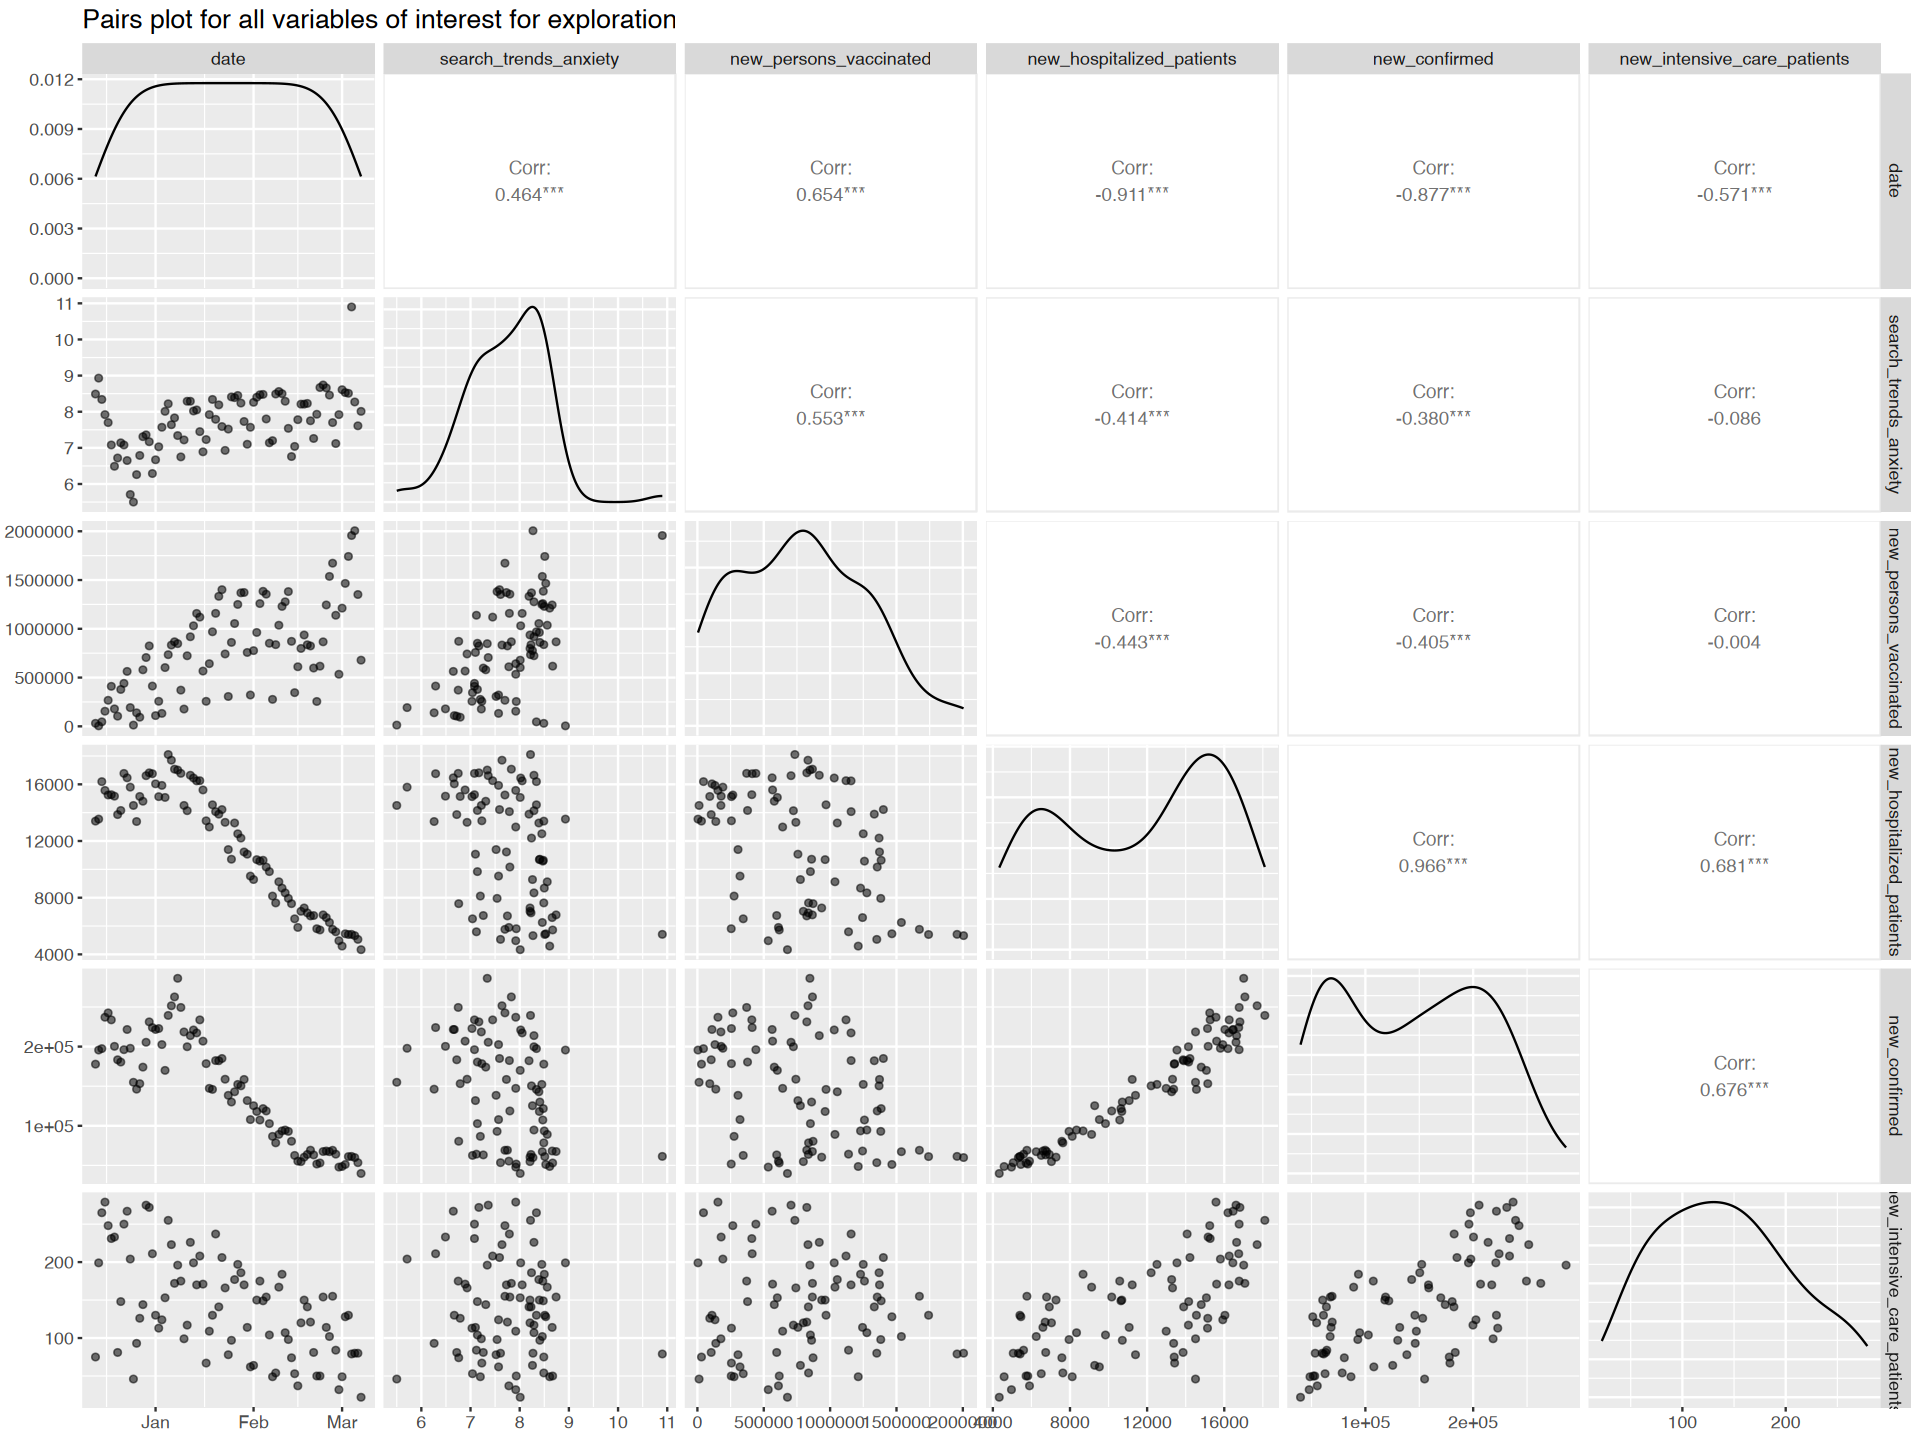

In [20]:
options(repr.plot.width = 16, repr.plot.height = 12) # change plot sizes to an appropiate size

ggpairs(us_selected, aes(alpha = 0.5)) +
    theme(text = element_text(size = 13)) +
    ggtitle("Pairs plot for all variables of interest for exploration")

<h4>Figure 1. Exploratory Analysis of Predictors and their Distribution</h4>

> From this pairwise plot, we observe that:
> 
> `new_persons_vaccinated` seems to have a moderate positive linear correlation with anxiety serach trend.
> 
> `new_hospitalized_patients` seems to have a weak negative linear correlation with anxiety serach trend.
>
> `new_confirmed` seems to have a weak negative linear correlation with anxiety serach trend.
>
> `date` seems to have a weak positive linear correlation with anxiety serach trend.

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`).”


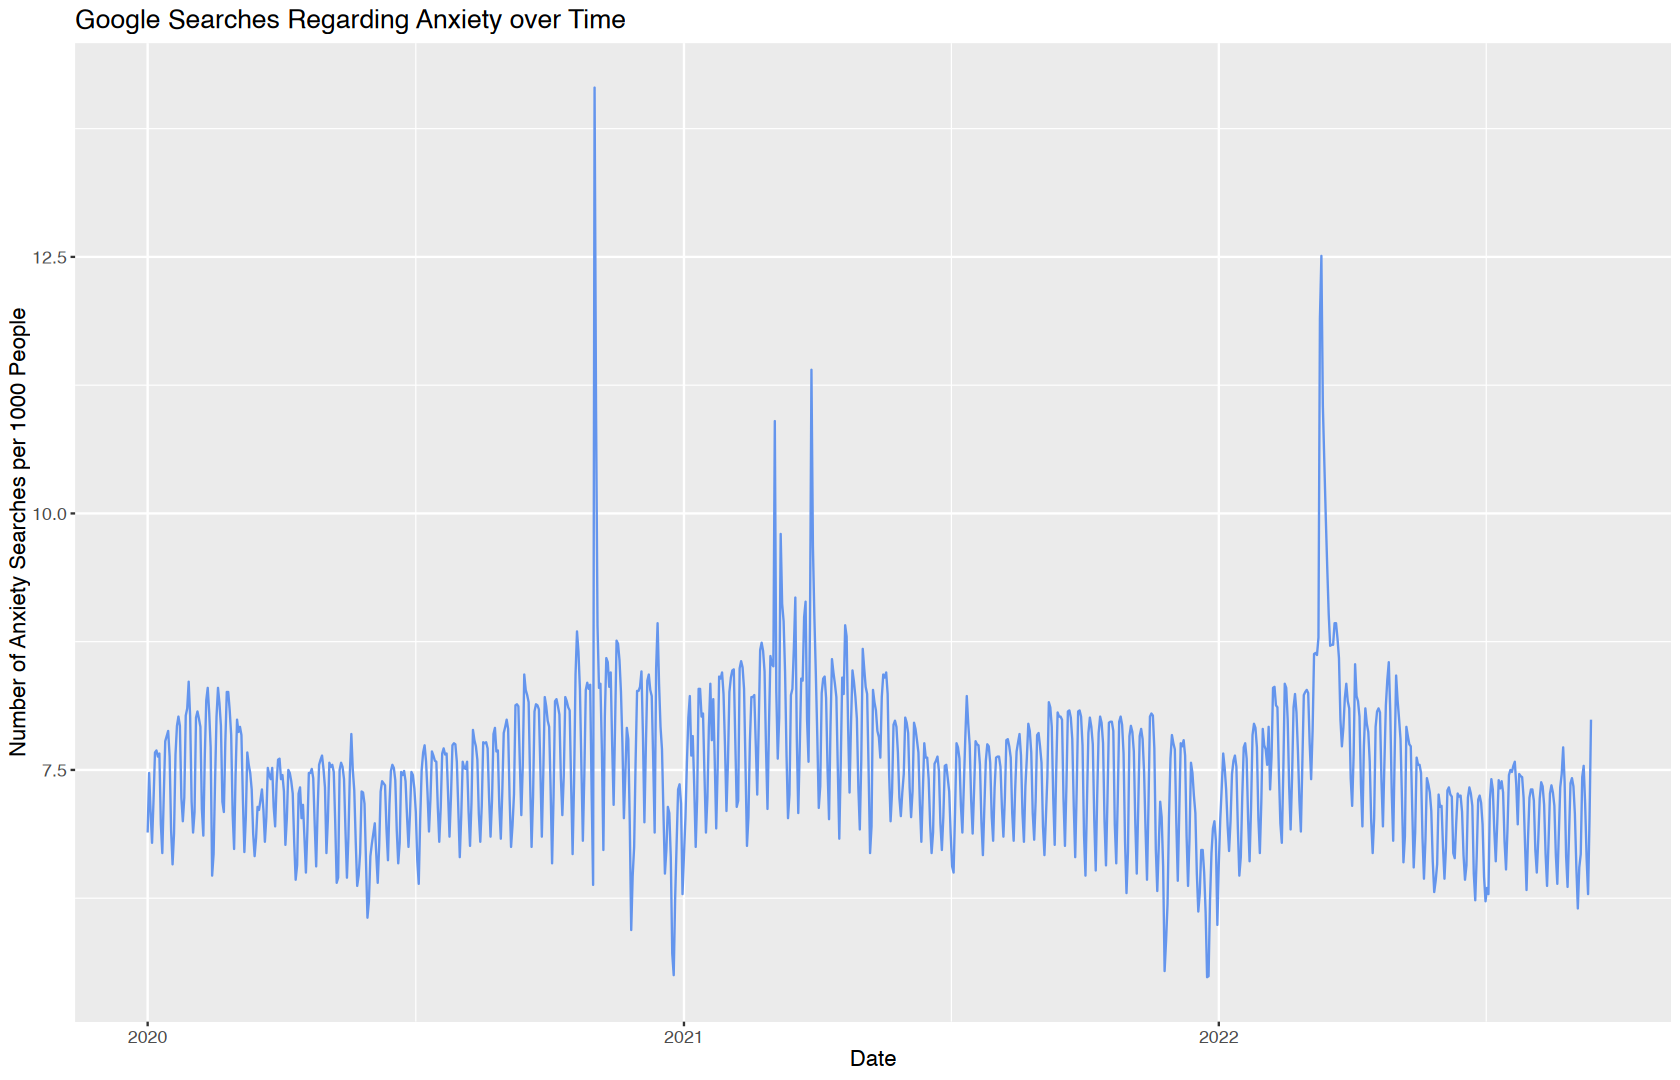

In [21]:
options(repr.plot.width = 14, repr.plot.height = 9) 


anxiety_time_plot <- ggplot(us_covid, aes(y = search_trends_anxiety, x = date)) +
                      geom_line(color = "cornflower blue")+
                      labs(title = "Google Searches Regarding Anxiety over Time",
                           x = "Date",
                           y = "Number of Anxiety Searches per 1000 People") +
                        theme(text = element_text(size = 13)) 


anxiety_time_plot

<h4>Figure 2: Time Series Plot of the Anxiety Google Search per 1000 People </h4>

> Observations: Anxiety searches seem to be consistent across the COVID-19 pandemic except for 3 peaks around winter of 2020, spring of 2021, and spring of 2022.

<h2>Picking the best features: Backward Selection </h2>

In [22]:
# split data into training and testing sets:
covid_split <- initial_split(us_selected, prop = 0.75, strata = search_trends_anxiety)
covid_train <- training(covid_split)
covid_test <- testing(covid_split)

# converts dates into number of days:
covid_train_numeric <- covid_train |> 
                       mutate(date = as.numeric(date))


# backward selection:
covid_backward_sel <- regsubsets(x = search_trends_anxiety ~ new_persons_vaccinated + 
                                                             new_hospitalized_patients +
                                                             new_confirmed +
                                                             new_intensive_care_patients + date,
                                  nvmax = 5,
                                  data = covid_train_numeric,
                                  method = "backward",)
covid_bwd_summary <- summary(covid_backward_sel)


In [23]:
#call only part of the summary table needed to show the model components
covid_bwd_summary[["which"]]

,(Intercept),new_persons_vaccinated,new_hospitalized_patients,new_confirmed,new_intensive_care_patients,date
1,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE
2,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE
3,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE
4,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


<h4>Table 4: The features being selected during each step of backward model selection </h4>

In [24]:
# summary of each model' performance


covid_bwd_summary_df <- tibble(n_input_variables = 1:5,
                               RSQ = covid_bwd_summary$rsq,
                               RSS = covid_bwd_summary$rss,
                               ADJ.R2 = covid_bwd_summary$adjr2)
covid_bwd_summary_df

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.2884503,28.44721,0.2763902
2,0.3263238,26.93306,0.3030936
3,0.3389724,26.42738,0.3041815
4,0.3408821,26.35103,0.2938023
5,0.3415181,26.32560,0.2816561


<h4>Table 5: RSQ, RSS, and Adjusted R^2 of each model with the number of features used</h4>

> To select the best-performing features to use to predict Anxiety google searches during the COVID-19 pandemic, we used backward selection to pick the set of features that would produce the best highest adjusted $R^2$ value. Higher $R^2$ value greater predicative ability of the feature variables for the response variable, thereby giving us the model that explained our data the best.
>
> As seen in Table 2, a model with 3 features provides the highest adjusted $R^2$ value at 0.304 based on the validation set. This model contains the variables `new_persons_vaccinated`, `new_hospitalized_patients`, and `date`, which agree with our thesis that higher vaccination rates and greater hospitalization may lead to greater anxiety search trend during COVID-19.

<h2>Creating the final model using selected variables </h2>

In [25]:
# create a mulitple linear regression model with the selected features
final_model <- lm(search_trends_anxiety ~ new_persons_vaccinated + new_hospitalized_patients + date,
                  data = covid_train_numeric)

#create a table with the regression results
tidy(final_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.299706e+02,2.128211e+02,1.080582,0.284433931
new_persons_vaccinated,9.612835e-07,2.886229e-07,3.330587,0.001524672
new_hospitalized_patients,-9.693034e-05,5.621467e-05,-1.724289,0.090075517
date,-1.189332e-02,1.138818e-02,-1.044357,0.300729373


<h4>Table 6: Coefficients and intercept of the selected linear model </h4>

> Linear formula of our model:
> 
> ***Anxiety search trend =  $9.612835 × 10^{-7}$ New vaccination $- 9.69×10^{-5}$ New hospitalization $-0.012$ date $+ 229.97$***

<h2>Testing the final model</h2>

In [26]:
# make sure dates are in numeric form as days since 1970-01-01
covid_test_numeric <- covid_test|> 
                      mutate(date = as.numeric(date))
# apply the model to predict test data
final_model_predictions <- predict(final_model, newdata = covid_test_numeric)

# find the RMSE between the model's prediction and the actual values
final_model_RMSE = rmse(preds = final_model_predictions,
                        actuals = covid_test_numeric$search_trends_anxiety)

# preview RMSE error rate:
final_model_RMSE

[1] 0.6054236

In [27]:
# preview R-squared:
glance(final_model)$r.squared

[1] 0.3389724

The current model has a root mean square error (RMSE) of 0.605, suggesting large discrepancy between the actual response value of anxiety search and the predicted response value. 

At the same time, this model has a $R^2$ of 0.34, which suggests that around 33.4% of variance in anxiety Google search trend during the COVID-19 pandemic is explained conjointly by new vaccination, new hospitalization, and progression of time.


## Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?


## References:
at least 4 citations relevant to the project (format is your choose, just be consistent across the references).